<a href="https://colab.research.google.com/github/akhilmenonh/fcc_ml_with_python/blob/CDIC/fcc_book_recommendation_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [65]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

--2025-10-01 11:09:30--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘book-crossings.zip.2’

book-crossings.zip. 100%[===================>]  24.88M  --.-KB/s    in 0.1s    

2025-10-01 11:09:30 (186 MB/s) - ‘book-crossings.zip.2’ saved [26085508/26085508]

Archive:  book-crossings.zip
replace BX-Book-Ratings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: BX-Book-Ratings.csv     
  inflating: BX-Books.csv            
  inflating: BX-Users.csv            


In [66]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

In [37]:
# add your code here - consider creating a new cell for each section of code

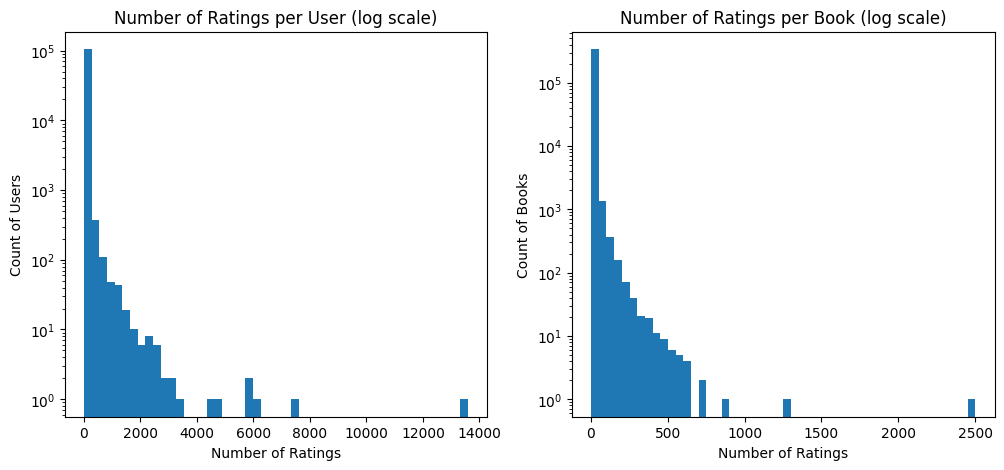

In [67]:
# Ratings per user
user_counts = df_ratings['user'].value_counts()
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(user_counts, bins=50, log=True)
plt.title('Number of Ratings per User (log scale)')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Users')

# Ratings per book
book_counts = df_ratings['isbn'].value_counts()
plt.subplot(1, 2, 2)
plt.hist(book_counts, bins=50, log=True)
plt.title('Number of Ratings per Book (log scale)')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Books')

plt.show()


In [68]:
# Counts of ratings per user
user_counts = df_ratings['user'].value_counts()

print("Ratings per user:")
print(user_counts.describe())  # Summary statistics
print("\nFirst 10 users and their rating counts:")
print(user_counts.head(10))

# Counts of ratings per book
book_counts = df_ratings['isbn'].value_counts()

print("\nRatings per book:")
print(book_counts.describe())  # Summary statistics
print("\nFirst 10 books and their rating counts:")
print(book_counts.head(10))


Ratings per user:
count    105283.000000
mean         10.920851
std          90.562825
min           1.000000
25%           1.000000
50%           1.000000
75%           4.000000
max       13602.000000
Name: count, dtype: float64

First 10 users and their rating counts:
user
11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
212898     4785
278418     4533
76352      3367
110973     3100
235105     3067
Name: count, dtype: int64

Ratings per book:
count    340556.000000
mean          3.376185
std          12.436252
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        2502.000000
Name: count, dtype: float64

First 10 books and their rating counts:
isbn
0971880107    2502
0316666343    1295
0385504209     883
0060928336     732
0312195516     723
044023722X     647
0679781587     639
0142001740     615
067976402X     614
0671027360     586
Name: count, dtype: int64


In [73]:
print(f"Books shape: {df_books.shape}")
print(df_books.head())

print(f"Ratings shape: {df_ratings.shape}")
print(df_ratings.head())


Books shape: (271379, 3)
         isbn                                              title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

                 author  
0    Mark P. O. Morford  
1  Richard Bruce Wright  
2          Carlo D'Este  
3      Gina Bari Kolata  
4       E. J. W. Barber  
Ratings shape: (1149780, 3)
     user        isbn  rating
0  276725  034545104X     0.0
1  276726  0155061224     5.0
2  276727  0446520802     0.0
3  276729  052165615X     3.0
4  276729  0521795028     6.0


In [74]:
min_user_ratings = 50  # minimum ratings per user
min_book_ratings = 100  # minimum ratings per book

# Filter users
user_counts = df_ratings['user'].value_counts()
filtered_users = user_counts[user_counts >= min_user_ratings].index
df_ratings_filtered = df_ratings[df_ratings['user'].isin(filtered_users)]

# Filter books
book_counts = df_ratings_filtered['isbn'].value_counts()
filtered_books = book_counts[book_counts >= min_book_ratings].index
df_ratings_filtered = df_ratings_filtered[df_ratings_filtered['isbn'].isin(filtered_books)]

print(f"Ratings after filtering: {df_ratings_filtered.shape[0]}")
print(f"Unique users after filtering: {df_ratings_filtered['user'].nunique()}")
print(f"Unique books after filtering: {df_ratings_filtered['isbn'].nunique()}")


Ratings after filtering: 48139
Unique users after filtering: 3060
Unique books after filtering: 306


In [75]:
merged_df = pd.merge(df_ratings_filtered, df_books, on='isbn', how='inner')
print(f"Merged DataFrame shape: {merged_df.shape}")
merged_df.head()


Merged DataFrame shape: (47828, 5)


,user,isbn,rating,title,author
0,276847,0446364193,0.0,Along Came a Spider (Alex Cross Novels),James Patterson
1,276925,002542730X,10.0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
2,276925,0316666343,0.0,The Lovely Bones: A Novel,Alice Sebold
3,276925,0385504209,8.0,The Da Vinci Code,Dan Brown
4,276925,0804106304,0.0,The Joy Luck Club,Amy Tan


In [76]:
book_user_matrix = merged_df.pivot_table(index='title', columns='user', values='rating').fillna(0)
print(f"User-Item matrix shape: {book_user_matrix.shape}")
book_user_matrix.head()


User-Item matrix shape: (298, 3060)


user,243,254,507,626,638,741,882,929,1025,1211,...,277928,277965,278026,278137,278144,278188,278418,278582,278633,278843
title,,,,,,,,,,,,,,,,,,,,,
1984,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Bend in the Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
# Convert the matrix to sparse format
book_user_sparse = csr_matrix(book_user_matrix.values)

# Initialize the model
model = NearestNeighbors(metric='cosine', algorithm='brute')

# Fit the model
model.fit(book_user_sparse)

print("KNN model fitted!")

KNN model fitted!


In [85]:
def get_recommends(book_title, n_recommendations=5):
    try:
        book_idx = book_user_matrix.index.get_loc(book_title)
    except KeyError:
        return [book_title, []]

    distances, indices = model.kneighbors(book_user_matrix.iloc[book_idx, :].values.reshape(1, -1), n_neighbors=n_recommendations + 1)

    recommendations = []
    for i in range(1, len(distances[0])):  # skip first index, which is the book itself
        idx = indices[0][i]
        distance = distances[0][i]
        recommended_book = book_user_matrix.index[idx]
        recommendations.append([recommended_book, distance])

    return [book_title, recommendations]


In [86]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2):
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [['The Lovely Bones: A Novel', np.float32(0.78933686)], ["The Pilot's Wife : A Novel", np.float32(0.8386467)], ['Icy Sparks', np.float32(0.849742)], ["The Book of Ruth (Oprah's Book Club (Paperback))", np.float32(0.8530508)], ['The Poisonwood Bible: A Novel', np.float32(0.8532598)]]]
You haven't passed yet. Keep trying!
